In [1]:
import cv2 as cv
import numpy as np
from matplotlib import pyplot as plt
from scipy.ndimage import gaussian_filter, rotate
import random
from skimage.util import random_noise

## Defining key functions for MIND descriptors and image processing. These functions include:
#### *mindDescriptor: Generates MIND descriptors for an image.*
#### *findCorrespondingPoints: Finds corresponding points between two images using MIND descriptors.*
#### *computeTransformation: Computes the homography transformation matrix between two sets of points.*
#### *processAngle: Processes an image at a given rotation angle and computes the transformation matrix and error*
#### *optimizeWindowSize: Finds the optimized window size for search radius for finding the corrosponding points*
#### *findKeyPoints: Finds the key points of image*



In [2]:
def mindDescriptor(image, radius=3):
    image = image.astype(np.float32)
    if radius > 0:
        xGrid, yGrid = np.meshgrid(np.arange(-radius, radius + 1), np.arange(-radius, radius + 1))
        xGrid = xGrid.flatten()
        yGrid = yGrid.flatten()
        midPoint = len(xGrid) // 2
        xGrid = np.concatenate([xGrid[:midPoint], xGrid[midPoint + 1:]])
        yGrid = np.concatenate([yGrid[:midPoint], yGrid[midPoint + 1:]])
    else:
        xGrid = np.array([1, -1, 0, 0])
        yGrid = np.array([0, 0, 1, -1])

    baseX, baseY = np.array([1, -1, 0, 0]), np.array([0, 0, 1, -1])

    displacement = np.zeros((*image.shape, len(baseX)), dtype=np.float32)
    sigma = 0.5
    for i in range(len(baseX)):
        xShift, yShift = baseX[i], baseY[i]
        shiftedImg = np.full_like(image, 0)
        rows, cols = image.shape
        
        xStartSrc = max(0, xShift)
        xEndSrc = min(cols, cols + xShift)
        yStartSrc = max(0, yShift)
        yEndSrc = min(rows, rows + yShift)
        
        xStartDst = max(0, -xShift)
        xEndDst = min(cols, cols - xShift)
        yStartDst = max(0, -yShift)
        yEndDst = min(rows, rows - yShift)
        
        shiftedImg[yStartDst:yEndDst, xStartDst:xEndDst] = image[yStartSrc:yEndSrc, xStartSrc:xEndSrc]
        displacement[..., i] = gaussian_filter((image - shiftedImg) ** 2, sigma)
    
    similarityVol = np.mean(displacement, axis=2)
    valRange = [0.001 * np.mean(similarityVol), 1000 * np.mean(similarityVol)]
    similarityVol = np.clip(similarityVol, min(valRange), max(valRange))
    descriptorBase = np.zeros((*image.shape, len(baseX)), dtype=np.float32)
    
    for i in range(len(baseX)):
        descriptorBase[..., i] = np.exp(-displacement[..., i] / similarityVol)
    
    mindDescriptor = np.zeros((*image.shape, len(xGrid)), dtype=np.float32)
    if radius > 0:
        for i in range(len(xGrid)):
            xShift, yShift = xGrid[i], yGrid[i]
            shiftedImg = np.full_like(image, 0)
            rows, cols = image.shape
            
            xStartSrc = max(0, xShift)
            xEndSrc = min(cols, cols + xShift)
            yStartSrc = max(0, yShift)
            yEndSrc = min(rows, rows + yShift)
            
            xStartDst = max(0, -xShift)
            xEndDst = min(cols, cols - xShift)
            yStartDst = max(0, -yShift)
            yEndDst = min(rows, rows - yShift)
            
            shiftedImg[yStartDst:yEndDst, xStartDst:xEndDst] = image[yStartSrc:yEndSrc, xStartSrc:xEndSrc]
            
            mindDescriptor[..., i] = np.exp(-gaussian_filter((image - shiftedImg) ** 2, sigma) / similarityVol)
    else:
        for i in range(len(baseX)):
            mindDescriptor[..., i] = descriptorBase[..., i]
    
    maxDescriptor = np.max(mindDescriptor, axis=2)
    for i in range(len(xGrid)):
        mindDescriptor[..., i] /= maxDescriptor
    
    return mindDescriptor

def findCorrespondingPoints(mriImage, rotatedPetImage, pointsMri, windowSize=50):
    mindMri = mindDescriptor(mriImage, radius=1)
    mindPet = mindDescriptor(rotatedPetImage, radius=1)
    pointsPet = []
    for point in pointsMri:
        x, y = point
        descriptorMri = mindMri[y, x, :]
        similarityMap = np.full(rotatedPetImage.shape, np.inf, dtype=np.float32)
        yStart = max(0, y - windowSize)
        yEnd = min(rotatedPetImage.shape[0], y + windowSize + 1)
        xStart = max(0, x - windowSize)
        xEnd = min(rotatedPetImage.shape[1], x + windowSize + 1)
        for py in range(yStart, yEnd):
            for px in range(xStart, xEnd):
                similarityMap[py, px] = np.sum((descriptorMri - mindPet[py, px, :]) ** 2)
        
        minIndex = np.unravel_index(np.argmin(similarityMap), similarityMap.shape)
        pointsPet.append(minIndex)
    
    return pointsPet

def computeTransformation(pointsMri, pointsPet):
    pointsMri = np.array(pointsMri, dtype=np.float32)
    pointsPet = np.array(pointsPet, dtype=np.float32)

    matrix, _ = cv.findHomography(pointsMri, pointsPet, cv.RANSAC, 5.0)
    return matrix

def normalizeMatrix(matrix):
    minVal = np.min(matrix)
    maxVal = np.max(matrix)
    normalizedMatrix = 2 * (matrix - minVal) / (maxVal - minVal) - 1
    return normalizedMatrix

def processAngle(mriImage, petImage, angle, pointsMri, windowSize=50, plot=False):
    rotatedPetImage = rotate(petImage, angle, reshape=True)
    center = (rotatedPetImage.shape[1] // 2, rotatedPetImage.shape[0] // 2)
    halfWidth = mriImage.shape[1] // 2
    halfHeight = mriImage.shape[0] // 2
    croppedRotatedPetImage = rotatedPetImage[center[1] - halfHeight:center[1] + halfHeight,
                                             center[0] - halfWidth:center[0] + halfWidth]
    
    pointsPet = findCorrespondingPoints(mriImage, croppedRotatedPetImage, pointsMri, windowSize)
    computedMatrix = computeTransformation(pointsMri, pointsPet)
    center = (petImage.shape[1] / 2, petImage.shape[0] / 2)
    rotationMatrix = cv.getRotationMatrix2D(center, angle, 1.0)
    rotationMatrix = np.vstack([rotationMatrix, [0, 0, 1]])
    normalizedComputedMatrix = normalizeMatrix(computedMatrix)
    normalizedRotationMatrix = normalizeMatrix(rotationMatrix)
    error = np.linalg.norm(normalizedRotationMatrix - normalizedComputedMatrix)
    
    if plot:
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
        ax1.imshow(mriImage, cmap='gray')
        ax1.set_title(f'MRI Image with Points (Angle: {angle}°)')
        ax1.axis('off')
        for i, point in enumerate(pointsMri):
            ax1.plot(point[0], point[1], 'ro')
            ax1.text(point[0], point[1], str(i + 1), color='yellow', fontsize=12)
        ax2.imshow(croppedRotatedPetImage, cmap='gray')
        ax2.set_title(f'Rotated and Resized PET Image with Points (Angle: {angle}°)')
        ax2.axis('off')
        for i, point in enumerate(pointsPet):
            ax2.plot(point[1], point[0], 'ro')
            ax2.text(point[1], point[0], str(i + 1), color='yellow', fontsize=12)
        plt.tight_layout()
        plt.show()
    return normalizedComputedMatrix, normalizedRotationMatrix, error

def optimizeWindowSize(mriImage, petImage, angle, pointsMri, windowSizes):
    bestWindowSize = None
    minError = float('inf')
    bestComputedMatrix = None
    bestRotationMatrix = None
    
    for windowSize in windowSizes:
        print(f"Testing window size: {windowSize}")
        computedMatrix, rotationMatrix, error = processAngle(mriImage, petImage, angle, pointsMri, windowSize, plot=False)
        print(f"Window size: {windowSize}, Error: {error}")
        
        if error < minError:
            minError = error
            bestWindowSize = windowSize
            bestComputedMatrix = computedMatrix
            bestRotationMatrix = rotationMatrix
    
    return bestWindowSize, bestComputedMatrix, bestRotationMatrix, minError

def findKeyPoints(image, numPoints=20):
    orb = cv.ORB_create()
    keypoints = orb.detect(image, None)
    totalKeypoints = len(keypoints)
    if totalKeypoints == 0:
        return []
    numPoints = min(numPoints, totalKeypoints)
    randomIndices = random.sample(range(totalKeypoints), numPoints)
    selectedKeypoints = [keypoints[i] for i in randomIndices]
    points = [(int(kp.pt[0]), int(kp.pt[1])) for kp in selectedKeypoints]
    return points


## Loading and displaying the MRI and PET images.

#### *This involves reading the images and displaying them side by side.*

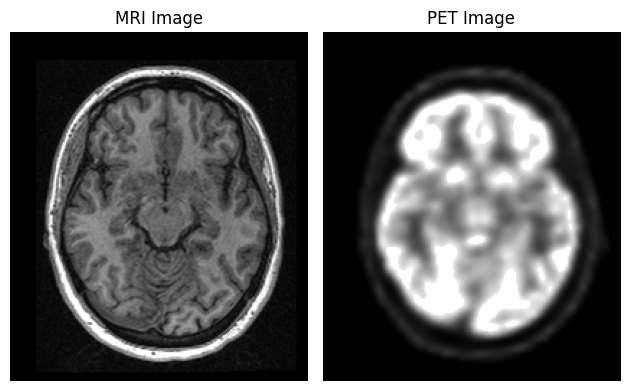

In [3]:
mriImage = cv.imread('MRI.png', 0)
petImage = cv.imread('PET.png', 0)
fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.imshow(mriImage, cmap='gray') 
ax1.set_title('MRI Image')
ax1.axis('off')
ax2.imshow(petImage, cmap='gray')
ax2.set_title('PET Image')
ax2.axis('off') 
plt.tight_layout()
plt.show()


## Generating a similarity heatmap for a specific point in the MRI image.
#### *I compute the MIND descriptors for both images and calculate the similarity between the descriptors at the specified point and all points in the PET image, displaying the results as a heatmap.*

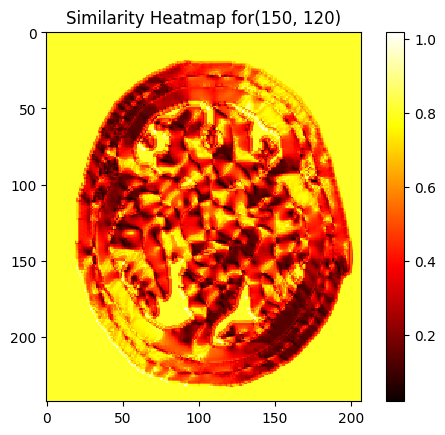

In [5]:
pointX, pointY = 150, 120
mindMri = mindDescriptor(mriImage, radius=1)
mindPet = mindDescriptor(petImage, radius=1)
similarityMap = np.zeros(mriImage.shape, dtype=np.float32)

for y in range(mriImage.shape[0]):
    for x in range(mriImage.shape[1]):
        similarityMap[y, x] = np.sum((mindMri[pointY, pointX, :] - mindPet[y, x, :]) ** 2)
similarityMap = (similarityMap ) / (similarityMap.max() - similarityMap.min())
plt.imshow(similarityMap, cmap='hot', interpolation='nearest')
plt.title(f'Similarity Heatmap for{pointX,pointY}')
plt.colorbar()
plt.show()

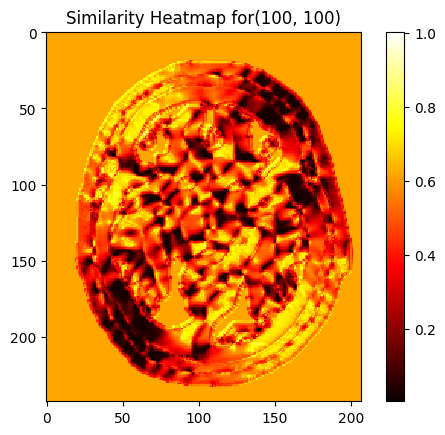

In [6]:
pointX, pointY = 100, 100
mindMri = mindDescriptor(mriImage, radius=1)
mindPet = mindDescriptor(petImage, radius=1)
similarityMap = np.zeros(mriImage.shape, dtype=np.float32)

for y in range(mriImage.shape[0]):
    for x in range(mriImage.shape[1]):
        similarityMap[y, x] = np.sum((mindMri[pointY, pointX, :] - mindPet[y, x, :]) ** 2)
similarityMap = (similarityMap) / (similarityMap.max() - similarityMap.min())
plt.imshow(similarityMap, cmap='hot', interpolation='nearest')
plt.title(f'Similarity Heatmap for{pointX,pointY}')
plt.colorbar()
plt.show()

## Displaying the MRI image and the PET image rotated by a specific angle.

#### *This demonstrates the effect of image rotation and sets up the next steps for comparison and transformation computation*

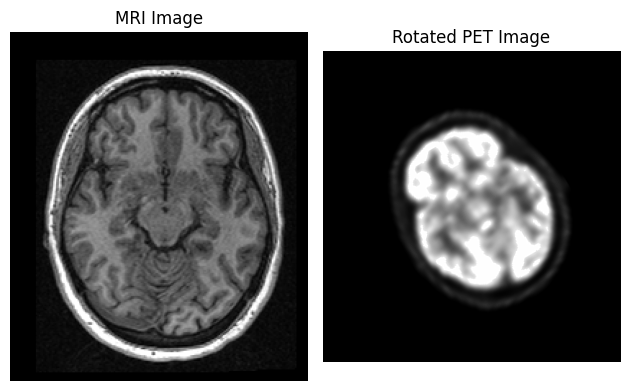

In [7]:
angle = 30
rotatedPetImage = rotate(petImage, angle, reshape=True)
fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.imshow(mriImage, cmap='gray')
ax1.set_title('MRI Image')
ax1.axis('off')
ax2.imshow(rotatedPetImage, cmap='gray')
ax2.set_title('Rotated PET Image')
ax2.axis('off')
plt.tight_layout()
plt.show()


## Finding the optimom windowsize

In [8]:
pointsMri = findKeyPoints(mriImage, numPoints=20)
angle = 30
windowSizes = range(5, 51, 5)
bestWindowSize, bestComputedMatrix, bestRotationMatrix, minError = optimizeWindowSize(mriImage, petImage, angle, pointsMri, windowSizes)
print('\n')
print(f'Best window size: {bestWindowSize}')
print('Best Computed Rotation Matrix:')
print(bestComputedMatrix)
print('Best Original Rotation Matrix:')
print(bestRotationMatrix)
print(f'Minimum Error: {minError}\n')

Testing window size: 5
Window size: 5, Error: 3.6123930542641673
Testing window size: 10
Window size: 10, Error: 1.9464058725072266
Testing window size: 15
Window size: 15, Error: 0.8911311922740397
Testing window size: 20
Window size: 20, Error: 2.949326635184326
Testing window size: 25
Window size: 25, Error: 2.9558574442185708
Testing window size: 30
Window size: 30, Error: 2.995445110045737
Testing window size: 35
Window size: 35, Error: 2.6501368233576748
Testing window size: 40
Window size: 40, Error: 2.3191766188754785
Testing window size: 45
Window size: 45, Error: 2.8880242775736567
Testing window size: 50
Window size: 50, Error: 3.501800551418615


Best window size: 15
Best Computed Rotation Matrix:
[[-0.53921264 -0.47224366 -1.        ]
 [-0.51399848 -0.51991266  1.        ]
 [-0.53008181 -0.5297756  -0.48767779]]
Best Original Rotation Matrix:
[[-0.16893197 -0.17530253 -1.        ]
 [-0.19270722 -0.16893197  1.        ]
 [-0.18400488 -0.18400488 -0.16660018]]
Minimum Error:

## Selecting random points in the MRI image and computing the transformation matrix for a rotated PET image.

#### *I evaluate the error between the computed transformation matrix and the actual rotation matrix.*

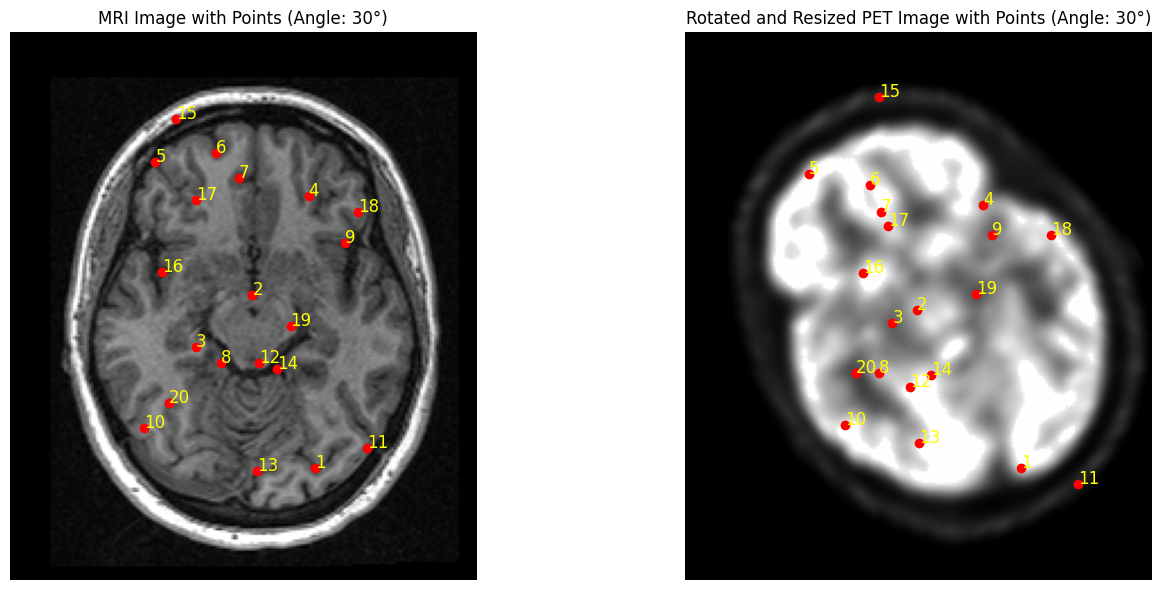

In [9]:
_=processAngle(mriImage, petImage, angle, pointsMri, bestWindowSize, plot=True)

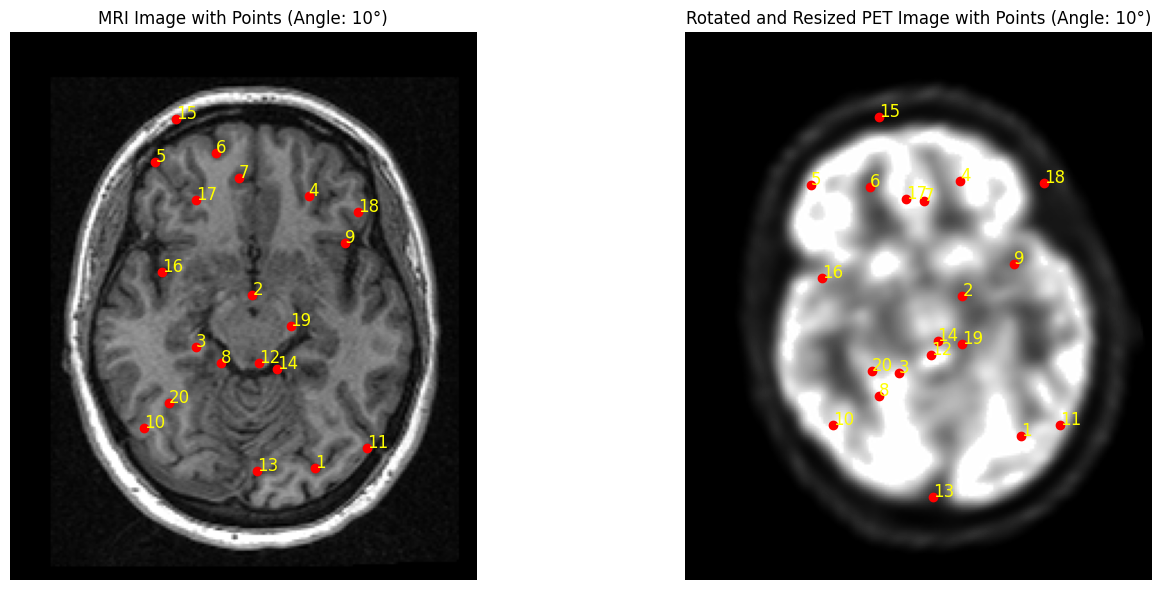

Angle: 10°
Computed Rotation Matrix:
[[-0.98784209 -1.          0.2918604 ]
 [-0.99587112 -0.99651247  1.        ]
 [-0.98571698 -0.98576912 -0.98114309]]
Original Rotation Matrix:
[[ 0.0426244   0.00139049 -1.        ]
 [-0.01626372  0.0426244   1.        ]
 [-0.00743661 -0.00743661  0.04339667]]
Error: 2.9558132856569204



Angle: 15°
Computed Rotation Matrix:
[[-0.98231163 -0.97078504 -0.19028927]
 [-0.96033052 -1.          1.        ]
 [-0.98851883 -0.9886761  -0.94623754]]
Original Rotation Matrix:
[[-0.01828612 -0.04231791 -1.        ]
 [-0.0599104  -0.01828612  1.        ]
 [-0.05111415 -0.05111415 -0.01712807]]
Error: 2.6158250576869326



Angle: 20°
Computed Rotation Matrix:
[[-0.99184769 -0.98336256  1.        ]
 [-0.97339754 -1.          0.85031596]
 [-0.99127123 -0.99141218 -0.9502255 ]]
Original Rotation Matrix:
[[-0.07090477 -0.08622183 -1.        ]
 [-0.10375232 -0.07090477  1.        ]
 [-0.09498708 -0.09498708 -0.06935922]]
Error: 3.110905348704696



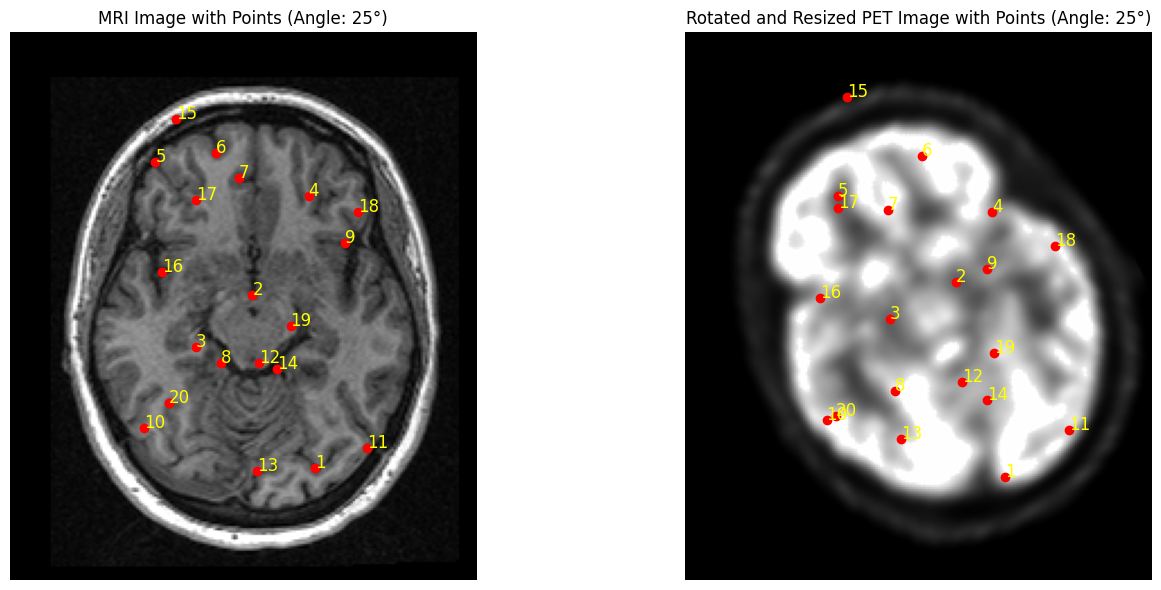

Angle: 25°
Computed Rotation Matrix:
[[-1.         -0.96796264  1.        ]
 [-0.96851338 -0.9834177  -0.96938454]
 [-0.98642589 -0.98633085 -0.95111301]]
Original Rotation Matrix:
[[-0.12049533 -0.13049143 -1.        ]
 [-0.14795941 -0.12049533  1.        ]
 [-0.13922542 -0.13922542 -0.11855905]]
Error: 3.591627510626117



In [10]:
angles = [10,15,20,25]
for angle in angles:
    computedMatrix, rotationMatrix, error = processAngle(mriImage, petImage, angle, pointsMri, bestWindowSize, plot=True)
    print(f'Angle: {angle}°')
    print('Computed Rotation Matrix:')
    print(computedMatrix)
    print('Original Rotation Matrix:')
    print(rotationMatrix)
    print(f'Error: {error}\n')


## Adding noise to the images and computing the transformation matrix and error for multiple rotation angles.

#### *This demonstrates the method's performance under noisy conditions, providing insight into its robustness and reliability.*

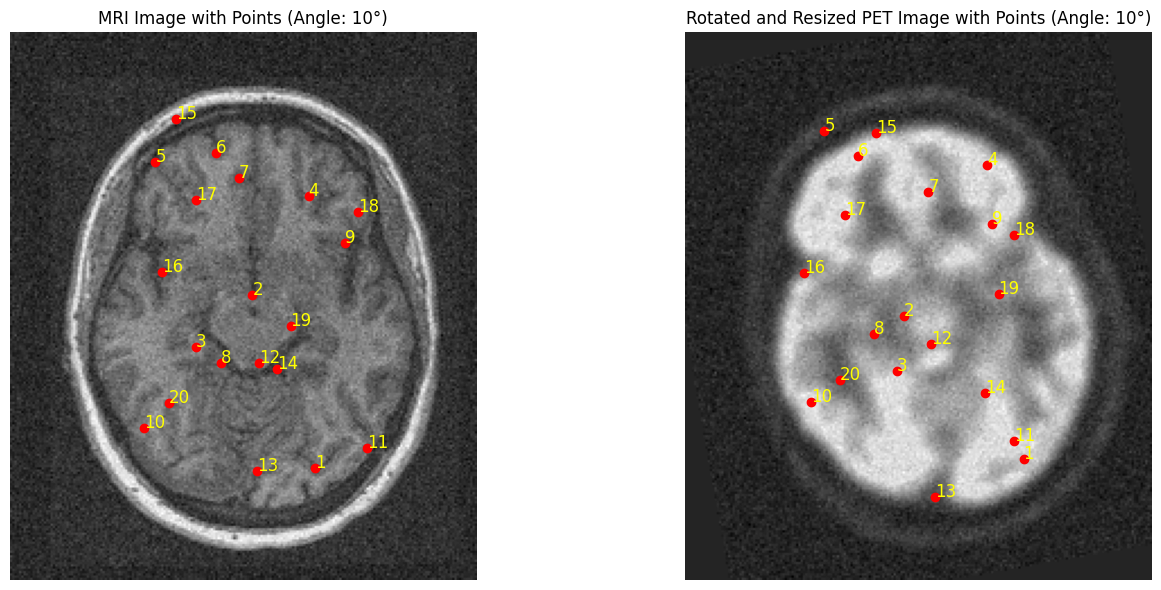

Angle: 10°
Computed Rotation Matrix:
[[-0.97470495 -0.96449514 -0.4422516 ]
 [-0.94988681 -1.          1.        ]
 [-0.98580708 -0.9859548  -0.93501251]]
Original Rotation Matrix:
[[ 0.0426244   0.00139049 -1.        ]
 [-0.01626372  0.0426244   1.        ]
 [-0.00743661 -0.00743661  0.04339667]]
Error: 2.666399482026265



Angle: 15°
Computed Rotation Matrix:
[[-0.96959174 -0.96751444  1.        ]
 [-0.93267734 -1.          0.78510907]
 [-0.97478987 -0.97502818 -0.9346307 ]]
Original Rotation Matrix:
[[-0.01828612 -0.04231791 -1.        ]
 [-0.0599104  -0.01828612  1.        ]
 [-0.05111415 -0.05111415 -0.01712807]]
Error: 3.1750965994360367



Angle: 20°
Computed Rotation Matrix:
[[-0.99588068 -0.92853999 -0.13329284]
 [-0.93277765 -1.          1.        ]
 [-0.99357312 -0.9935789  -0.9195969 ]]
Original Rotation Matrix:
[[-0.07090477 -0.08622183 -1.        ]
 [-0.10375232 -0.07090477  1.        ]
 [-0.09498708 -0.09498708 -0.06935922]]
Error: 2.490901608814912



Angle: 25°
Computed Rotation Matrix:
[[-1.         -0.93465733 -0.57978232]
 [-0.95910531 -0.9864881   1.        ]
 [-0.99070681 -0.99049091 -0.92781141]]
Original Rotation Matrix:
[[-0.12049533 -0.13049143 -1.        ]
 [-0.14795941 -0.12049533  1.        ]
 [-0.13922542 -0.13922542 -0.11855905]]
Error: 2.2603668283393907



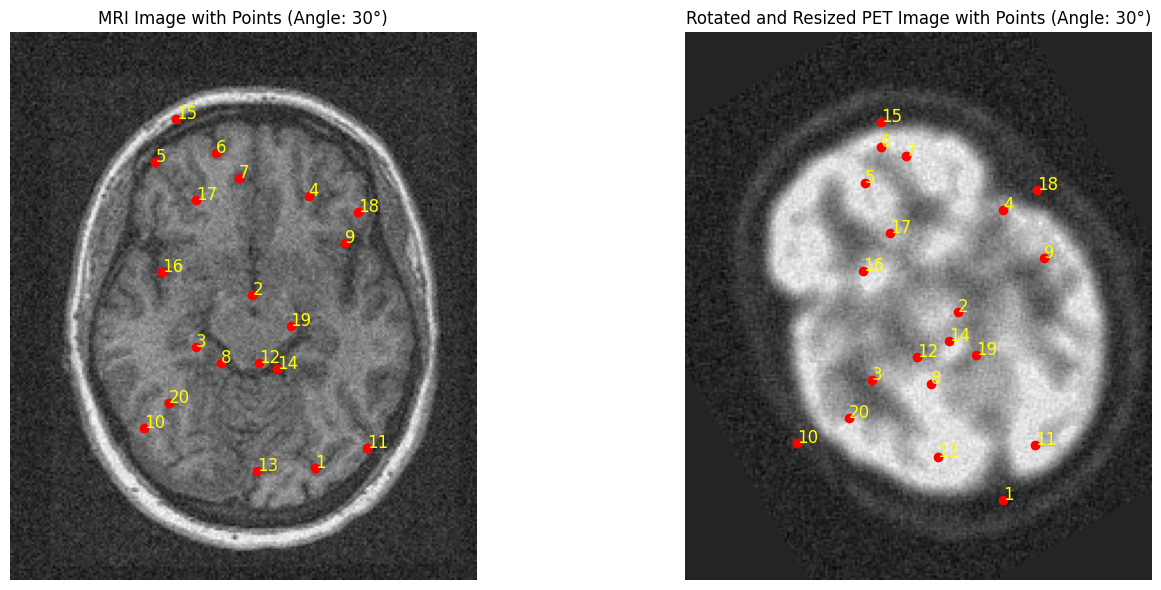

Angle: 30°
Computed Rotation Matrix:
[[ 0.94733563  1.         -0.15616085]
 [ 0.98883109  0.96273942 -1.        ]
 [ 0.94931661  0.94944025  0.97045526]]
Original Rotation Matrix:
[[-0.16893197 -0.17530253 -1.        ]
 [-0.19270722 -0.16893197  1.        ]
 [-0.18400488 -0.18400488 -0.16660018]]
Error: 3.7253425797615884



In [11]:
noiseStd = 15  
noisyMriImage = mriImage + noiseStd * np.random.randn(*mriImage.shape)
noisyPetImage = petImage + noiseStd * np.random.randn(*petImage.shape)
angles = [10,15,20,25,30]
for angle in angles:
    computedMatrix, rotationMatrix, error = processAngle(noisyMriImage, noisyPetImage, angle, pointsMri, bestWindowSize, plot=True)
    print(f'Angle: {angle}°')
    print('Computed Rotation Matrix:')
    print(computedMatrix)
    print('Original Rotation Matrix:')
    print(rotationMatrix)
    print(f'Error: {error}\n')


angle: 10°
computedRotationMatrix:
[[ 0.94576399  0.99300069 -1.        ]
 [ 1.          0.92769748  0.50948736]
 [ 0.92851976  0.92856999  0.97878289]]
originalRotationMatrix:
[[ 0.0426244   0.00139049 -1.        ]
 [-0.01626372  0.0426244   1.        ]
 [-0.00743661 -0.00743661  0.04339667]]
error: 2.5461286206280547



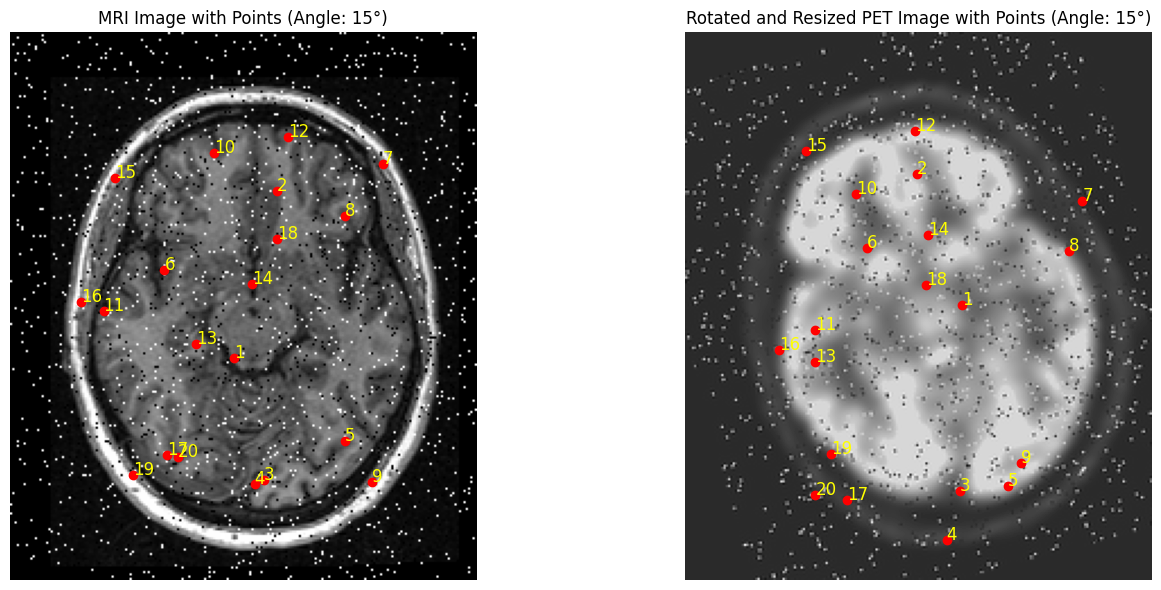

angle: 15°
computedRotationMatrix:
[[ 0.97426117  0.98728514 -1.        ]
 [ 1.          0.96241569 -0.57549585]
 [ 0.95544781  0.9551926   0.95527196]]
originalRotationMatrix:
[[-0.01828612 -0.04231791 -1.        ]
 [-0.0599104  -0.01828612  1.        ]
 [-0.05111415 -0.05111415 -0.01712807]]
error: 3.095801662624723



angle: 20°
computedRotationMatrix:
[[-1.         -0.99583659  1.        ]
 [-0.99136283 -0.9940314  -0.11648535]
 [-0.99039299 -0.99037485 -0.97051653]]
originalRotationMatrix:
[[-0.07090477 -0.08622183 -1.        ]
 [-0.10375232 -0.07090477  1.        ]
 [-0.09498708 -0.09498708 -0.06935922]]
error: 3.3155281926050044



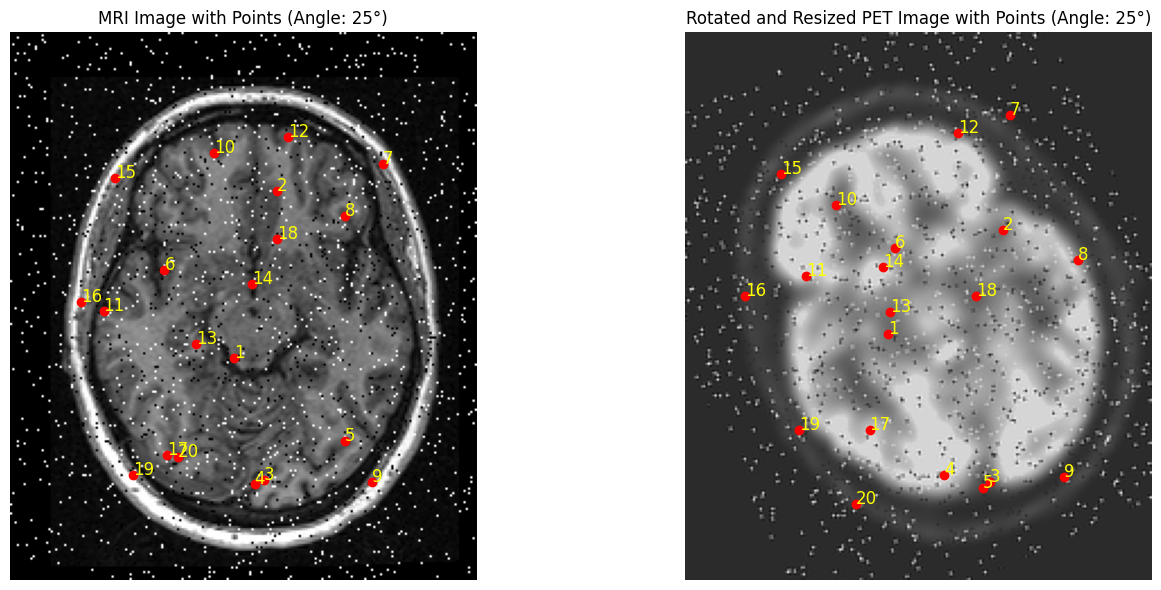

angle: 25°
computedRotationMatrix:
[[-1.         -0.92787205 -0.53308792]
 [-0.94262489 -0.99044479  1.        ]
 [-0.99040963 -0.99041835 -0.90558796]]
originalRotationMatrix:
[[-0.12049533 -0.13049143 -1.        ]
 [-0.14795941 -0.12049533  1.        ]
 [-0.13922542 -0.13922542 -0.11855905]]
error: 2.2547982173891126



angle: 30°
computedRotationMatrix:
[[-1.         -0.91962068  1.        ]
 [-0.93508363 -0.98347541 -0.0360319 ]
 [-0.98271021 -0.98250317 -0.89856448]]
originalRotationMatrix:
[[-0.16893197 -0.17530253 -1.        ]
 [-0.19270722 -0.16893197  1.        ]
 [-0.18400488 -0.18400488 -0.16660018]]
error: 3.056787674487804



In [17]:
spAmount = 0.05
spSaltVsPepper = 0.5
noisyMriImageSp = random_noise(mriImage, mode='s&p', amount=spAmount, salt_vs_pepper=spSaltVsPepper) 
noisyPetImageSp = random_noise(petImage, mode='s&p', amount=spAmount, salt_vs_pepper=spSaltVsPepper) 
angles = [10,15,20,25,30]
for angle in angles:
    computedMatrix, rotationMatrix, error = processAngle(noisyMriImageSp, noisyPetImageSp, angle, pointsMri, bestWindowSize, plot=True)
    print(f'angle: {angle}°')
    print('computedRotationMatrix:')
    print(computedMatrix)
    print('originalRotationMatrix:')
    print(rotationMatrix)
    print(f'error: {error}\n')